In [1]:
from torchaudio.datasets import LJSPEECH
from g2p_en import G2p

class LJSpeechTTS(LJSPEECH):
    def __init__(self, root_dir, download=False, process_first=False):
        super(LJSpeechTTS, self).__init__(root_dir, download=False)
        self.process_first = process_first
        self.g2p = G2p()
        if self.process_first:
            self._flist = list(map(self._addPhonemeTranscript, self._flist))
        
    def _addPhonemeTranscript(self, data):
        normalized_transcript = data[-1]
        phonemes = self.g2p(normalized_transcript)
        out = (*data, phonemes)
        
        return out
        
    def __getitem__(self, i):
        item = super().__getitem__(i)
        if not self.process_first:
            item = self._addPhonemeTranscript(item)
        return item

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
dataset = LJSpeechTTS("../data/")

In [4]:
phoneme_vocab = dataset.g2p.phonemes
len(phoneme_vocab), phoneme_vocab[:3]

(74, ['<pad>', '<unk>', '<s>'])

In [5]:
class Vocab:
    def __init__(self, array):
        self.array = array
        self.dict = { val: i for i, val in enumerate(self.array) }
    
    def __getitem__(self, val):
        if type(val) == int:
            return self.array[val]
        elif type(val) == str:
            return self.dict[val]
        else:
            raise Exception("Wrong key type")

In [6]:
vocab = Vocab(phoneme_vocab)

In [7]:
vocab["<pad>"], vocab[0]

(0, '<pad>')

In [8]:
encode_word = lambda word: vocab[word]

In [9]:
list(map(encode_word, phoneme_vocab))[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
waveform = dataset[0][0]
sample_rate = dataset[0][1]
waveform.shape, sample_rate

(torch.Size([1, 212893]), 22050)

In [11]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

In [12]:
melspectrogram_transformation = MelSpectrogram(sample_rate, n_fft=1024, hop_length=256)

In [13]:
mel_spectrogram = melspectrogram_transformation(waveform)[0]
mel_spectrogram.shape

torch.Size([128, 832])

In [14]:
amp_to_db = AmplitudeToDB(stype="power", top_db=80)

In [15]:
spec = amp_to_db(mel_spectrogram)
spec.shape

torch.Size([128, 832])

In [16]:
import matplotlib.pyplot as plt

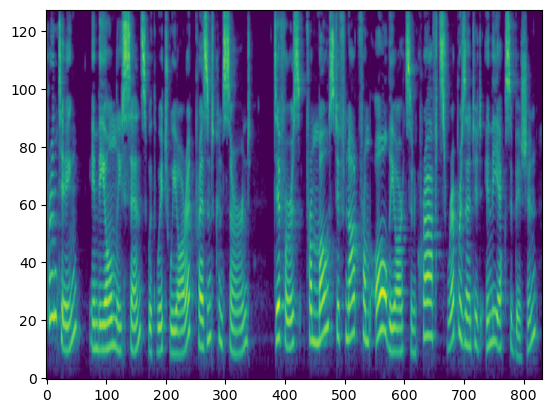

In [17]:
plt.imshow(spec, aspect="auto", origin="lower");

In [18]:
import IPython

In [19]:
IPython.display.Audio(waveform.numpy(), rate=sample_rate)

In [20]:
from torchaudio.datasets import LJSPEECH
from torchaudio.transforms import MelSpectrogram
from torch.nn.functional import pad
from g2p_en import G2p
import re

class LJSpeechTTS(LJSPEECH):
    def __init__(self, root_dir, download=False, sample_rate=22050, 
                 n_fft=1024, hop_length=256):
        super(LJSpeechTTS, self).__init__(root_dir, download=False)
        self.n_fft, self.hop_length, self.g2p = n_fft, hop_length, G2p()
        self.phoneme_vocab = Vocab(self.g2p.phonemes+[' '])
        self.mel_transform = MelSpectrogram(sample_rate, self.n_fft, 
                                            hop_length=self.hop_length)
        
        
    def __getitem__(self, i):
        waveform, sample_rate, _, norm_transcript = super().__getitem__(i)
        
        phonemes = self.g2p(norm_transcript)
        filtered_phonemes = list(filter(lambda x: re.search('[A-Z]',x), phonemes))
        encoded_phonemes = list(map(lambda phoneme: self.phoneme_vocab[phoneme], filtered_phonemes))
        
        mel_spectrogram = self.mel_transform(waveform)
        
        return (waveform, sample_rate, mel_spectrogram, norm_transcript, encoded_phonemes)

In [21]:
dataset = LJSpeechTTS("../data/")

In [22]:
waveform, sample_rate, spec, _, phonemes = dataset[31]
phonemes[:5], list(map(lambda x: dataset.phoneme_vocab[x], phonemes))[:5]

([10, 48, 24, 71, 67], ['AH0', 'N', 'D', 'Y', 'UW1'])

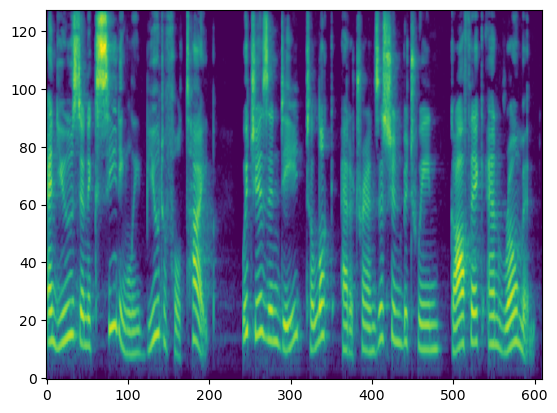

In [23]:
plt.imshow(amp_to_db(spec[0]), aspect="auto", origin="lower");

In [24]:
IPython.display.Audio(waveform.numpy(), rate=sample_rate)

In [25]:
import librosa

In [26]:
energy = torch.from_numpy(librosa.stft(waveform.numpy(), n_fft=1024, hop_length=256)[0]).norm(dim=1).numpy()

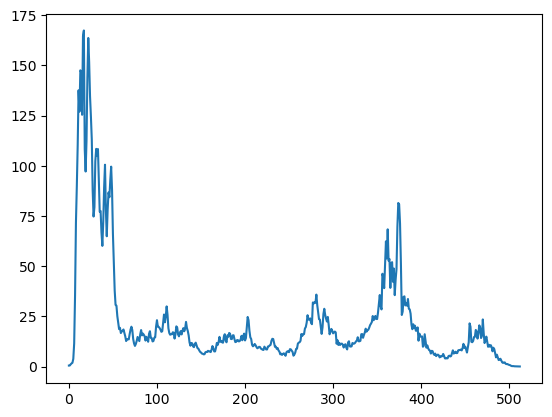

In [27]:
plt.plot(energy);

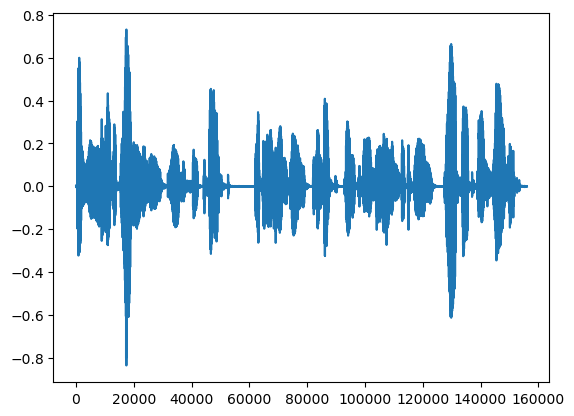

In [28]:
plt.plot(waveform.numpy()[0])

In [29]:
sample_rate

22050

In [30]:
dataset.g2p.cmu

{'a': [['AH0'], ['EY1']],
 'a.': [['EY1']],
 'a42128': [['EY1',
   'F',
   'AO1',
   'R',
   'T',
   'UW1',
   'W',
   'AH1',
   'N',
   'T',
   'UW1',
   'EY1',
   'T']],
 'aaa': [['T', 'R', 'IH2', 'P', 'AH0', 'L', 'EY1']],
 'aaberg': [['AA1', 'B', 'ER0', 'G']],
 'aachen': [['AA1', 'K', 'AH0', 'N']],
 'aachener': [['AA1', 'K', 'AH0', 'N', 'ER0']],
 'aaker': [['AA1', 'K', 'ER0']],
 'aalseth': [['AA1', 'L', 'S', 'EH0', 'TH']],
 'aamodt': [['AA1', 'M', 'AH0', 'T']],
 'aancor': [['AA1', 'N', 'K', 'AO2', 'R']],
 'aardema': [['AA0', 'R', 'D', 'EH1', 'M', 'AH0']],
 'aardvark': [['AA1', 'R', 'D', 'V', 'AA2', 'R', 'K']],
 'aaron': [['EH1', 'R', 'AH0', 'N']],
 "aaron's": [['EH1', 'R', 'AH0', 'N', 'Z']],
 'aarons': [['EH1', 'R', 'AH0', 'N', 'Z']],
 'aaronson': [['EH1', 'R', 'AH0', 'N', 'S', 'AH0', 'N'],
  ['AA1', 'R', 'AH0', 'N', 'S', 'AH0', 'N']],
 "aaronson's": [['EH1', 'R', 'AH0', 'N', 'S', 'AH0', 'N', 'Z'],
  ['AA1', 'R', 'AH0', 'N', 'S', 'AH0', 'N', 'Z']],
 'aarti': [['AA1', 'R', 'T', 'IY2'